In [ ]:
# pwd = "/Users/youtao/code"
pwd = "/scratch/ty296"
hdf5_data_path = '/scratch/ty296/hdf5_data/'
groupname = 'L'
p_fixed_name = 'p_ctrl'
p_fixed_value = 0.4
import os
print(os.getcwd())
import sys
sys.path.append('/scratch/ty296/CT_MPS_mini')
import h5py
import numpy as np

/scratch/ty296


In [2]:
# View singular values from your HDF5 file
filename = os.path.join(pwd, "hdf5_data_combined/sv_combined_p_ctrl0.4.h5")
print(filename)
real_num = 0
with h5py.File(filename, 'r') as f:
    # Get the first key to examine
    first_key = list(f.keys())[real_num]
    print(f"Examining key: {first_key}")
    
    # Get the singular values array
    sv_array = f[first_key][()]
    
    # Display basic info
    print(f"Shape: {sv_array.shape}")
    print(f"Data type: {sv_array.dtype}")
    print(f"Number of singular values: {len(sv_array)}")
    
    # Display the actual values
    print(f"\nSingular values:")
    print(sv_array)
    
    # Display metadata
    print(f"\nMetadata:")
    for attr_name, attr_value in f[first_key].attrs.items():
        print(f"  {attr_name}: {attr_value}")


/scratch/ty296/hdf5_data_combined/sv_combined_p_ctrl0.4.h5


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/scratch/ty296/hdf5_data_combined/sv_combined_p_ctrl0.4.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
with h5py.File(filename, 'r') as f:
    L_target = 20
    matching_groups = []
    
    print(f"Searching for groups with L={L_target}...")
    print("=" * 80)
    
    # Loop through all realizations
    for key in f.keys():
        # Check if this group has L=24
        if 'L' in f[key].attrs and f[key].attrs['L'] == L_target:
            matching_groups.append(key)
    
    print(f"Found {len(matching_groups)} groups with L={L_target}")
    print()
    
    # # Display information for each matching group
    # for i, key in enumerate(matching_groups):
    #     sv_array = f[key][()]
    #     attrs = dict(f[key].attrs)
        
    #     print(f"Group {i+1}: {key}")
    #     print(f"  L = {attrs.get('L')}")
    #     print(f"  p_ctrl = {attrs.get('p_ctrl')}")
    #     print(f"  p_proj = {attrs.get('p_proj')}")
    #     print(f"  maxbond = {attrs.get('maxbond')}")
    #     print(f"  Singular value array shape: {sv_array.shape}")
    #     print(f"  Singular values: {sv_array}")
    #     print(f"  Max SV: {np.max(sv_array):.6e}")
    #     print(f"  Min SV: {np.min(sv_array):.6e}")
    #     print(f"  Number of SVs: {len(sv_array)}")
    #     print("-" * 60)


Searching for groups with L=20...


Found 79898 groups with L=20



In [ ]:
# Plot singular values for all L=24 groups
L24_groups = []

with h5py.File(filename, 'r') as f:
    L_target = 20
    
    # Collect all L=24 groups
    for key in f.keys():
        if 'L' in f[key].attrs and f[key].attrs['L'] == L_target:
            L24_groups.append(key)


In [ ]:
dict_min_sv = {}
for key in L24_groups[:]:
    with h5py.File(filename, 'r') as f:
        # print(f[key].attrs.keys())
        min_sv = min(f[key][()])
        # print(f[key].attrs.keys())
        p_proj = f[key].attrs['p_proj']
        seed = f[key].attrs['seed']
        if p_proj in dict_min_sv:
            dict_min_sv[p_proj].append((np.log10(min_sv), seed))
        else:
            dict_min_sv[p_proj] = [(np.log10(min_sv), seed)]
        # if min_sv < 1e-10:
        #     print(min_sv, p_proj)

        # print(min_sv.shape)


In [ ]:
# for min_sv, seed in dict_min_sv[0.2]:
#     if min_sv < -10:
#         print(min_sv, seed)

0 0.2 3970
1 0.24210526315789474 3970
2 0.28421052631578947 3970
3 0.3263157894736842 3988
4 0.3684210526315789 4000
5 0.4105263157894737 4000
6 0.45263157894736844 4000


/tmp/ipykernel_4433/446729839.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


7 0.49473684210526314 4000
8 0.5368421052631579 4000
9 0.5789473684210527 4000
10 0.6210526315789474 4000
11 0.6631578947368421 4000


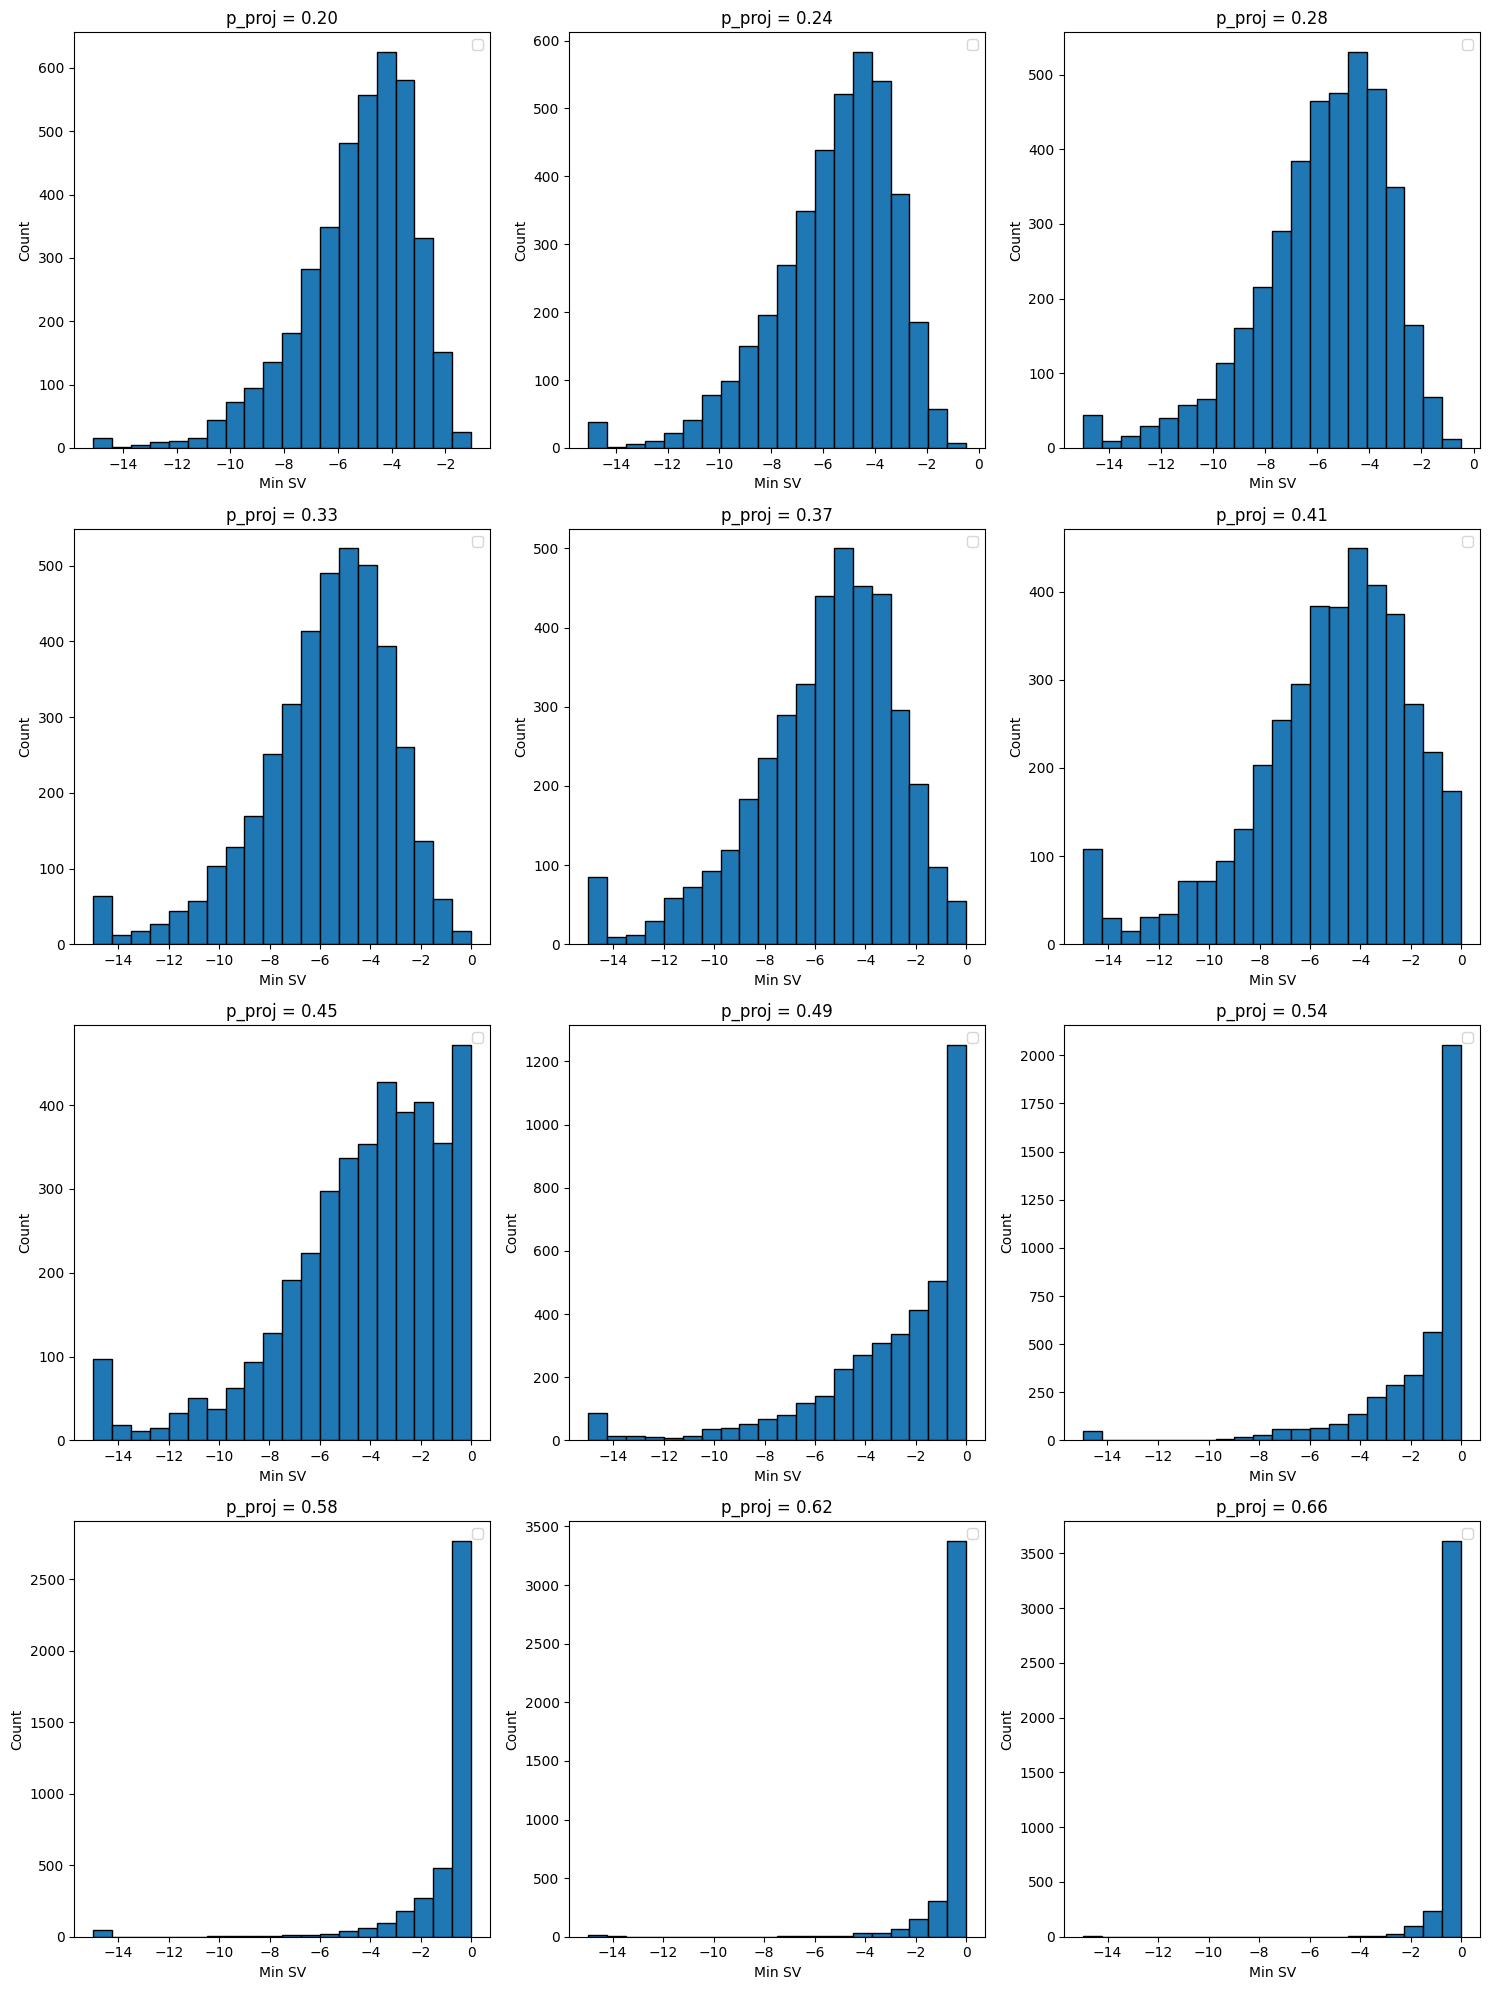

In [ ]:
import matplotlib.pyplot as plt
from read_hdf5_func import calculate_variance_and_error, calculate_mean_and_error

# Create a figure with subplots arranged based on number of p_proj values
n_plots = 12
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

# Plot histogram for each p_proj value
for idx, (p_proj, sv_seed_list) in enumerate(sorted(dict_min_sv.items())[0:n_plots]):
    # print(idx, p_proj, sv_seed_list)
    min_svs = [sv for sv, seed in sv_seed_list]
    print(idx, p_proj, len(min_svs))
    ax = axes[idx]
    mean, sem = calculate_mean_and_error(min_svs)
    var, semvar = calculate_variance_and_error(min_svs)
    ax.hist(min_svs, bins=20, edgecolor='black')
    ax.set_title(f'p_proj = {p_proj:.2f}')
    ax.set_xlabel('Min SV')
    ax.set_ylabel('Count')
    # ax.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.4f}')
    # ax.axvline(mean + var, color='blue', linestyle='--', label=f'Variance: {var:.4f}')
    # ax.axvline(mean - var, color='blue', linestyle='--')
    ax.legend()

# Remove any empty subplots
for idx in range(len(dict_min_sv), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [ ]:
from read_hdf5_func import von_neumann_entropy_sv
dict = {}
with h5py.File(filename, 'r') as f:
    for key in L24_groups:
        entropy = von_neumann_entropy_sv(f[key][()], n=0, positivedefinite=False, threshold=1e-15)
        p_proj = f[key].attrs['p_proj']
        if p_proj in dict:
            dict[p_proj].append(entropy)
        else:
            dict[p_proj] = [entropy]
        # print(entropy)
        # print(f[key].attrs['p_proj'])

In [ ]:
print(len(dict))

20


3970 0.2
3970 0.24210526315789474
3970 0.28421052631578947
3988 0.3263157894736842
4000 0.3684210526315789
4000 0.4105263157894737
4000 0.45263157894736844
4000 0.49473684210526314
4000 0.5368421052631579
4000 0.5789473684210527
4000 0.6210526315789474
4000 0.6631578947368421
4000 0.7052631578947368
4000 0.7473684210526316
4000 0.7894736842105263
4000 0.8315789473684211
4000 0.8736842105263158
4000 0.9157894736842105
4000 0.9578947368421052
4000 1.0


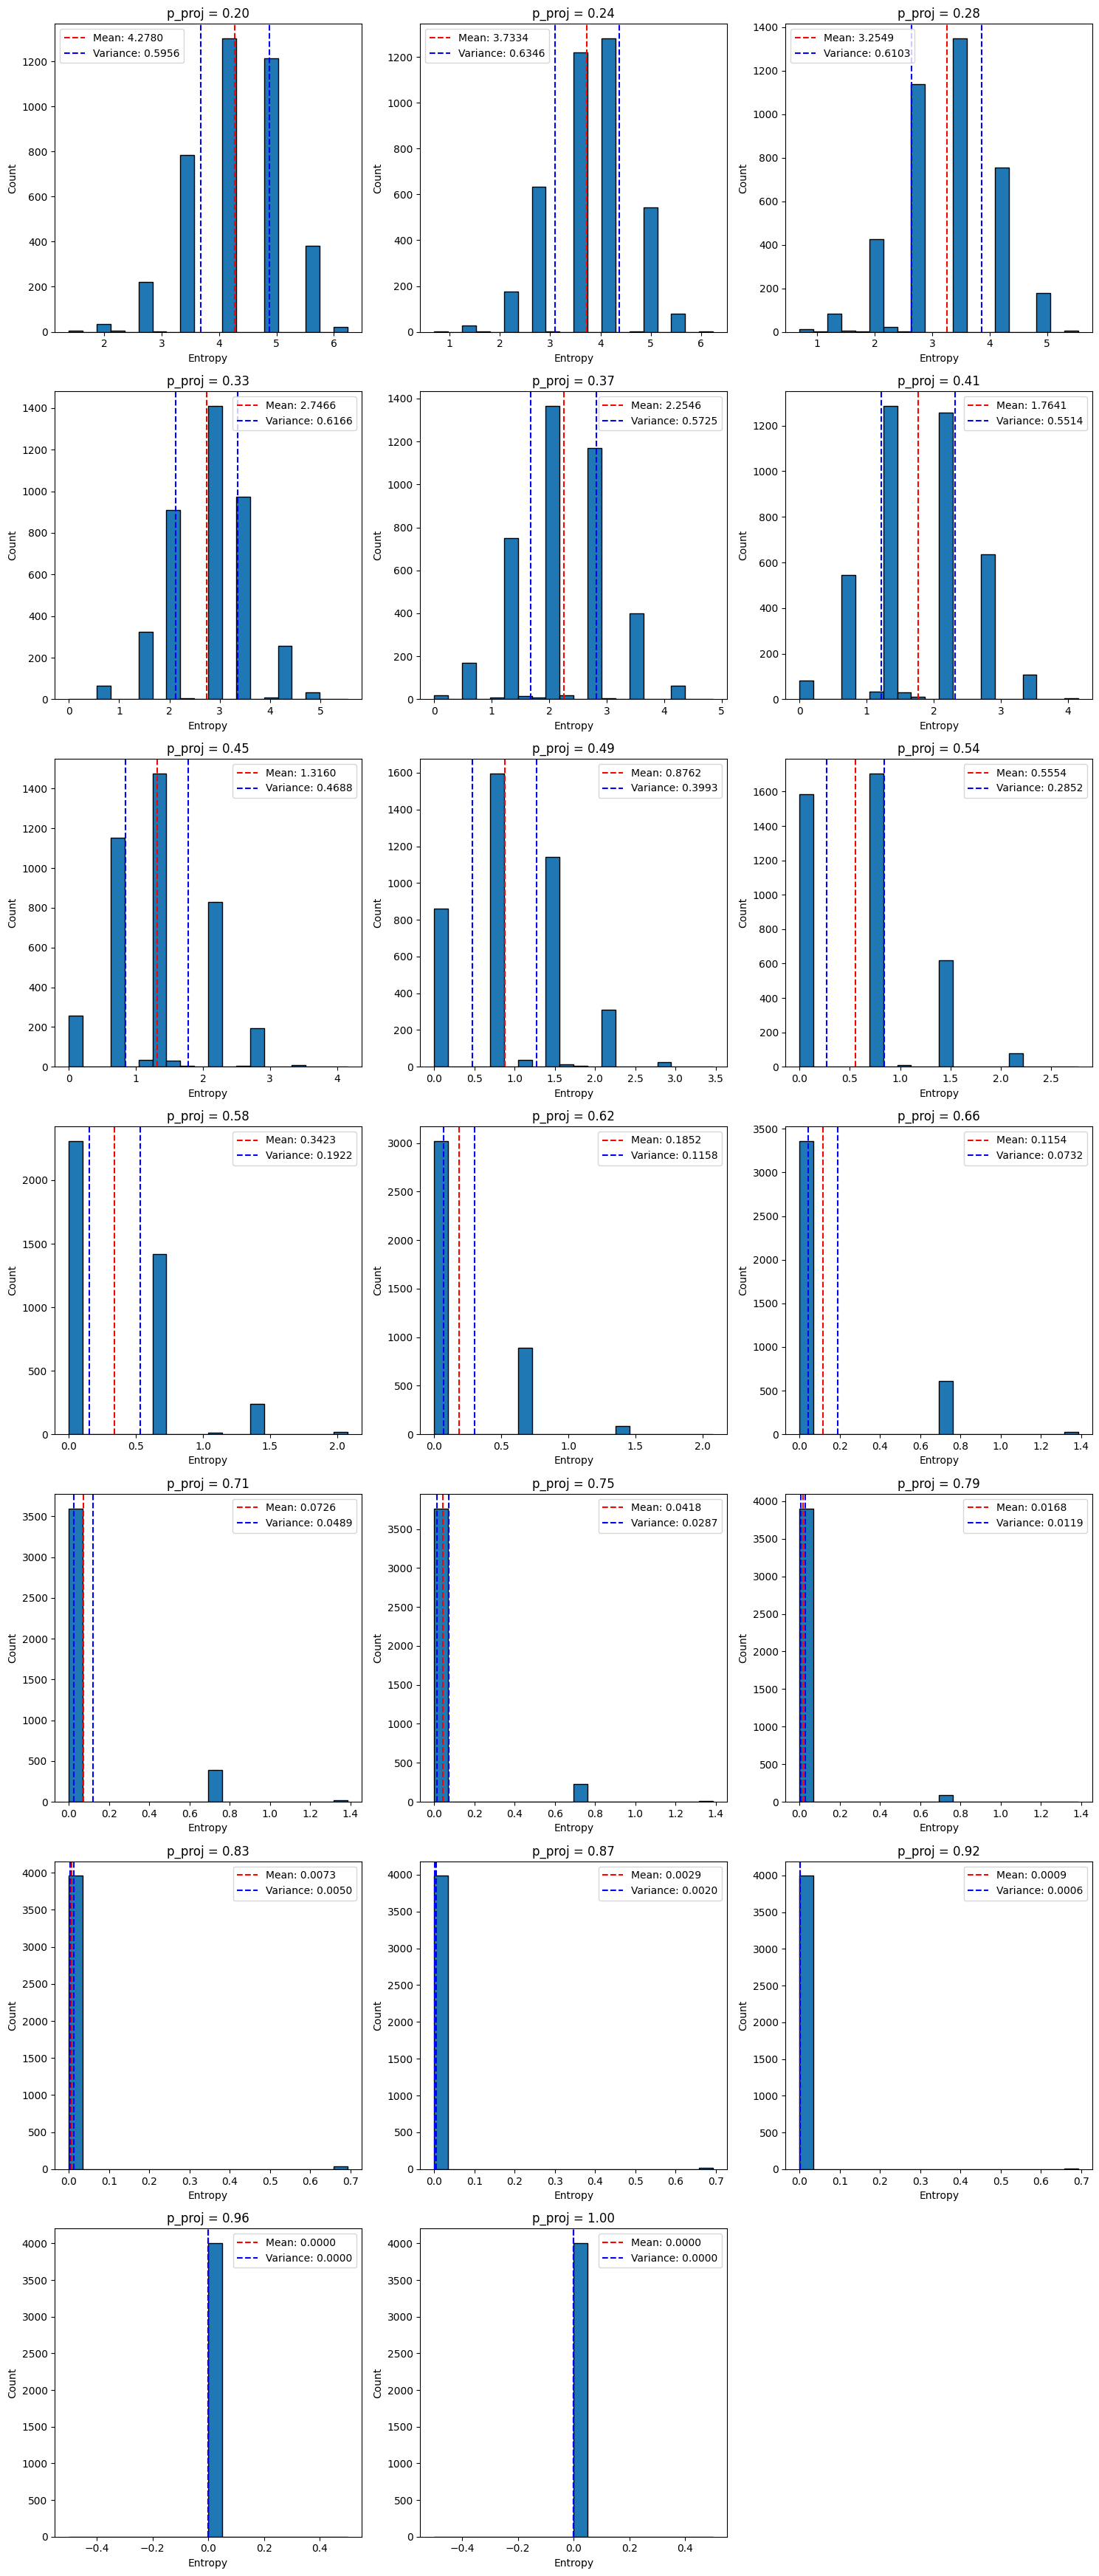

In [ ]:
import matplotlib.pyplot as plt
from read_hdf5_func import calculate_variance_and_error, calculate_mean_and_error

# Create a figure with subplots arranged based on number of p_proj values
n_plots = len(dict)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

# Plot histogram for each p_proj value
for idx, (p_proj, entropies) in enumerate(sorted(dict.items())):
    ax = axes[idx]
    mean, sem = calculate_mean_and_error(entropies)
    var, semvar = calculate_variance_and_error(entropies)
    print(len(entropies), p_proj)
    ax.hist(entropies, bins=20, edgecolor='black')
    ax.set_title(f'p_proj = {p_proj:.2f}')
    ax.set_xlabel('Entropy')
    ax.set_ylabel('Count')
    ax.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.4f}')
    ax.axvline(mean + var, color='blue', linestyle='--', label=f'Variance: {var:.4f}')
    ax.axvline(mean - var, color='blue', linestyle='--')
    ax.legend()

# Remove any empty subplots
for idx in range(len(dict), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


In [ ]:
dict_maxbond = {}
with h5py.File(filename, 'r') as f:
    for key in L24_groups:
        maxbond = f[key].attrs['maxbond']
        p_proj = f[key].attrs['p_proj']
        if p_proj in dict_maxbond:
            dict_maxbond[p_proj].append(maxbond)
        else:
            dict_maxbond[p_proj] = [maxbond]
        # print(entropy)
        # print(f[key].attrs['p_proj'])

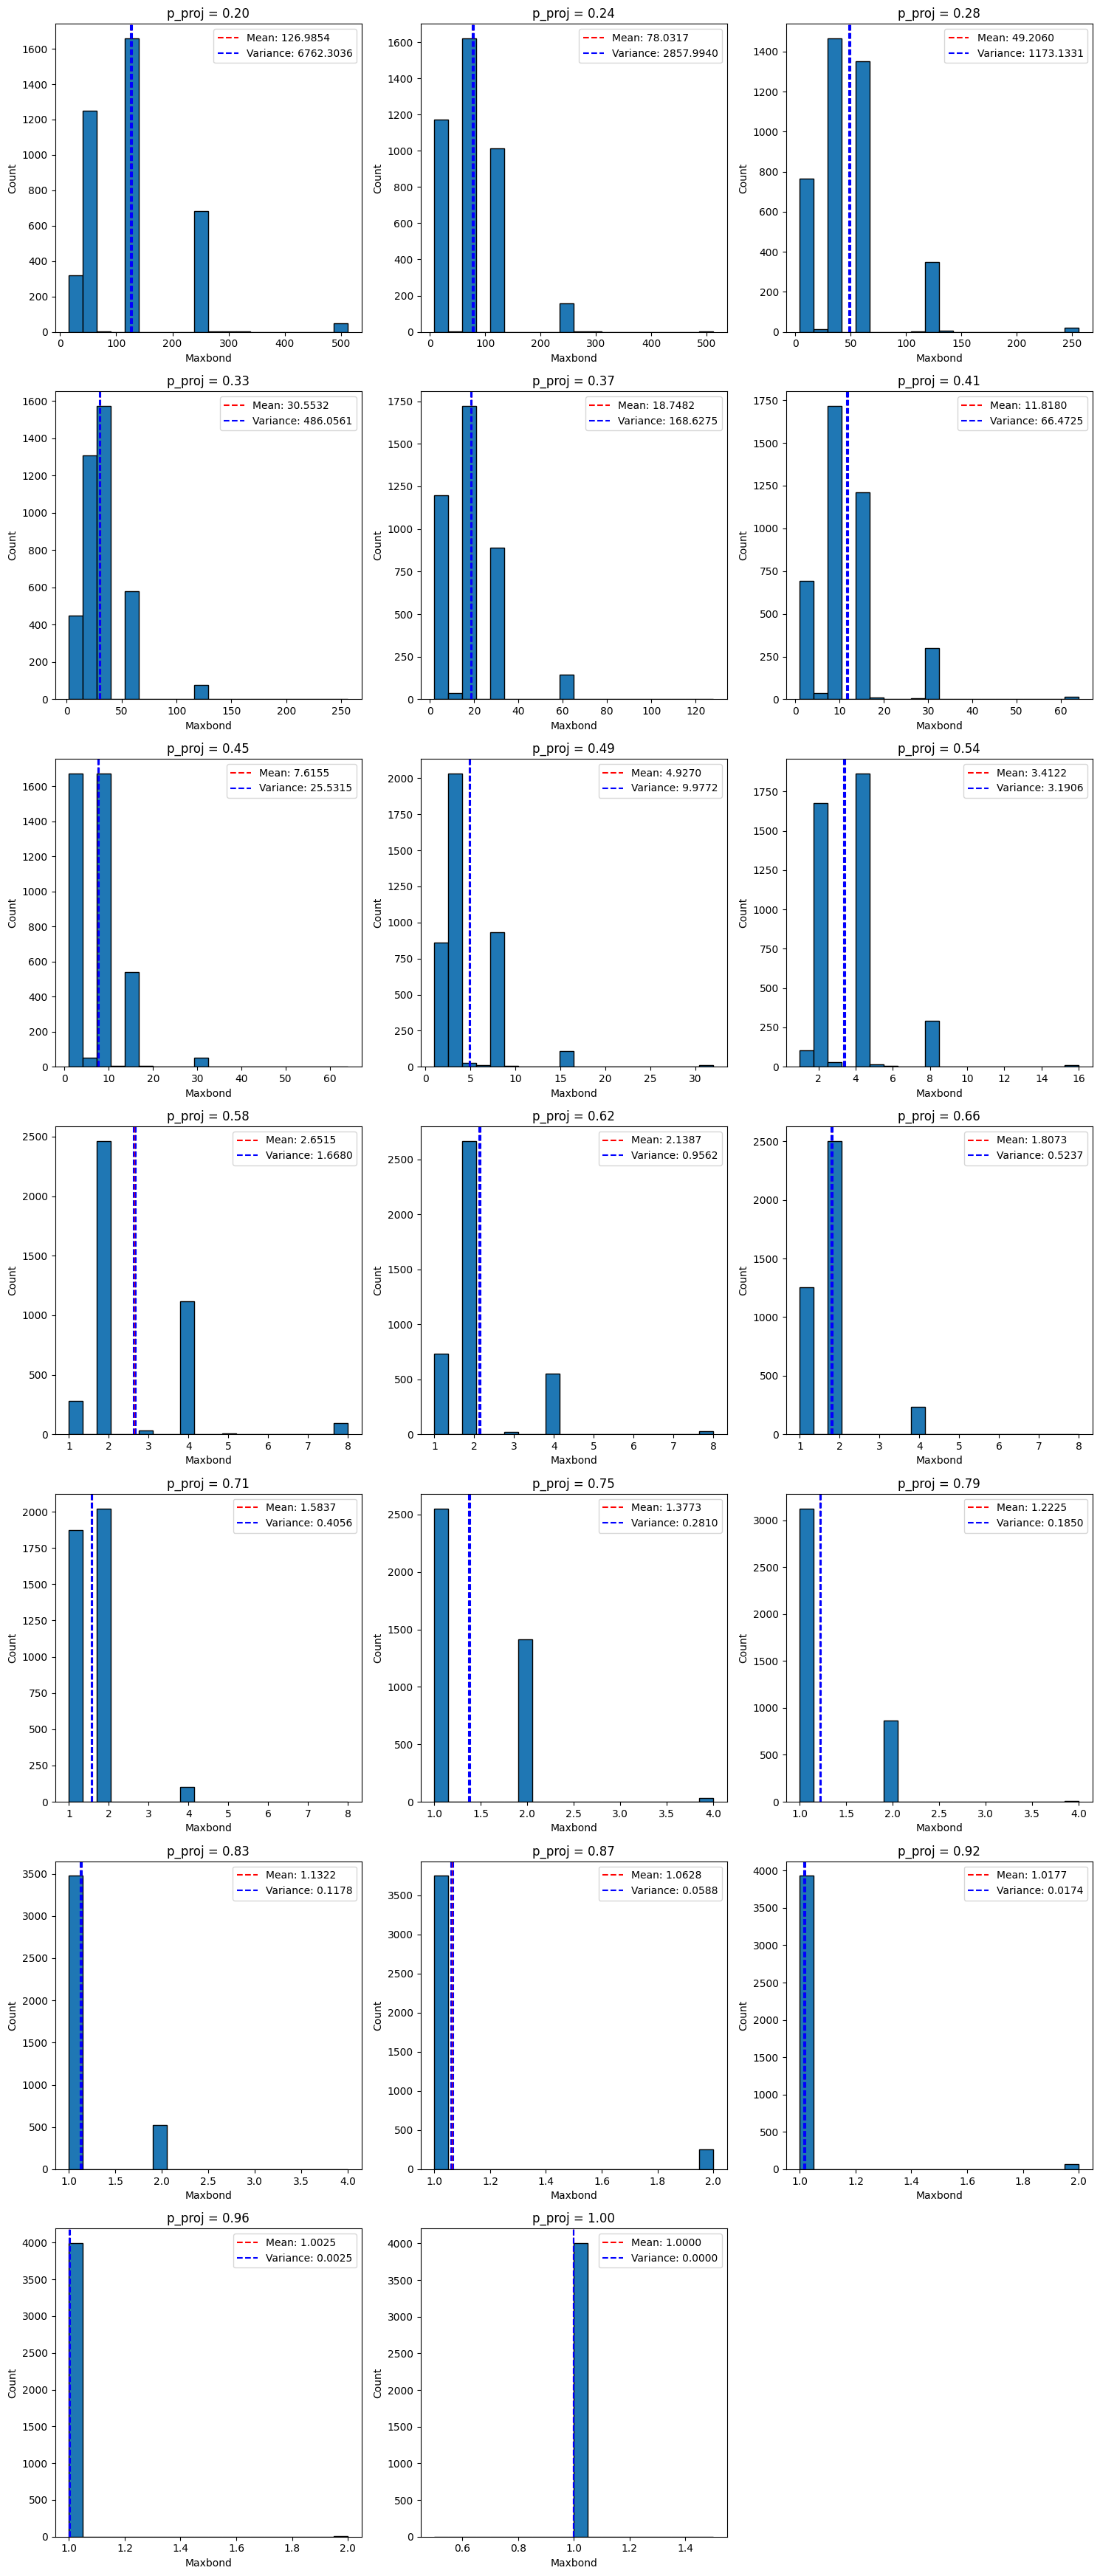

In [ ]:
import matplotlib.pyplot as plt
from read_hdf5_func import calculate_variance_and_error, calculate_mean_and_error

# Create a figure with subplots arranged based on number of p_proj values
n_plots = len(dict_maxbond)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

# Plot histogram for each p_proj value
for idx, (p_proj, maxbonds) in enumerate(sorted(dict_maxbond.items())):
    ax = axes[idx]
    mean, sem = calculate_mean_and_error(maxbonds)
    var, semvar = calculate_variance_and_error(maxbonds)
    # print(maxbonds)
    ax.hist(maxbonds, bins=20, edgecolor='black')
    ax.set_title(f'p_proj = {p_proj:.2f}')
    ax.set_xlabel('Maxbond')
    ax.set_ylabel('Count')
    ax.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.4f}')
    ax.axvline(mean + sem, color='blue', linestyle='--', label=f'Variance: {var:.4f}')
    ax.axvline(mean - sem, color='blue', linestyle='--')
    ax.legend()

# Remove any empty subplots
for idx in range(len(dict), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()
